# Exercise 04 - HDR and Noise
## 4.1 - HDR-Reconstruction (70 P)
In this exercise your task is to reconstruct High Dynamic Range images by combining a set of Low Dynamic Range images (LDR images) taken with different exposure times. 
For the reconstruction you are tasked to implement the algorithm by Robertson et. al. given in their paper "Dynamic Range Improvement through Multiple Exposures". 

#### Here is a quick reminder of the important concepts:
The sensor in a camera converts incoming photons into a digital image. The dynamic range of any sensor is limited - e.g. for Low Dynamic Range (LDR) there are 256 brightness values in a 8 bit per channel image. This means that the sensor is somehow assigning a digital number to the measured incoming photon count. Thus, the pixel values generated by the sensor is a mapping from the true irradiance to some values and is described as _response function_ of the camera:
$$v_j = f_{resp}(t_i \cdot x_j)$$
Where $v_j$, the pixel value reported by the camera for pixel $j$, $x_j$, is proportional to the number of photons that hit the pixel surface during exposure time $t_i$. Here we refer to $x_i$ as irradiance value. $f_{resp}$ is the response function that converts this irradiance value to a digital value in the dynamic range of the LDR image.

The goal when reconstructing an HDR image is to compute the best estimate for $x_j$, by combining the $v_j$ from multiple LDR images while considering possible errors caused by noise, over and under exposure.

In order to do so the inverse of the response function $f_{resp}^{-1}$ must be known. This means for every possible digital value $y \in \lbrace 0, \dots, 255\rbrace$ we need to know the range of irradiance values $t \cdot x$ that will be mapped onto this value. In the Robertson et. al. paper the response curve is defined by the boundaries $I_m$ of those ranges. E.g. all irradiance values smaller than $I_0$ produce a pixel value of $0$ and all irradiance values between $I_{m-1}$ and $I_m$ produce the pixel value of $m$.

The response curve for a camera is typically not known, however if an estimate for an HDR image $x_j$ is known it is possible to compute the $I_m \forall m \in {0,\dots,255}$ that best explains the HDR image given all LDR images.

The Robertson et. al. paper describes a method for estimating both the HDR image as well as the correct response curve by alternating between HDR reconstruction with the current best estimate for a response curve and then using this HDR image to update the response curve in an alternating fashion.

This method was explained in the lecture and more formally is derived in the provided paper (see pdf). In this exercise you will be guided through a way of implementing this method in python.

## Input and expected result
If you execute the next two cells you'll get an overview of the LDR input images and a correctly reconstructed HDR image, which was tonemapped for displaying purpose.

In [1]:
%matplotlib widget
import os
from typing import List, Tuple

import cv2
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from flt_reader import read_flt_image
from tqdm.notebook import tqdm

LDR input images:
Tonemapped ground truth hdr image (expected outcome):


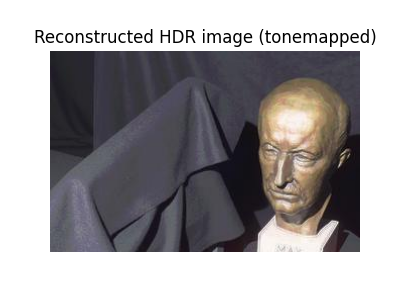

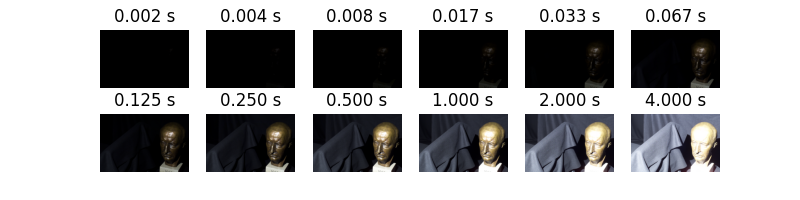

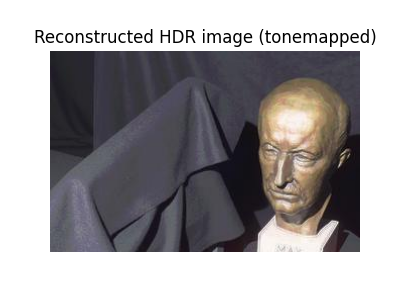

In [2]:
# Load the ldr image list.
with open("max.list", "r") as exposure_list_file:
    file_content = exposure_list_file.readlines()
exposures = [s.rstrip().split(" ") for s in file_content]
# load the images and extract exposure time (ms)
images = [imageio.imread(os.path.join("input_images", exp[0])) for exp in exposures]
exposure_times = [1 / float(exp[1]) for exp in exposures]

# load ground truth result image
hdr_gt = imageio.imread(os.path.join("input_images", "reconstructed.jpg"))


print("LDR input images:")
fig, axs = plt.subplots(2, len(images) // 2, figsize=[8, 2])
for j in range(2):
    for i in range(len(images) // 2):
        idx = j * len(images) // 2 + i
        axs[j][i].imshow(images[idx])
        axs[j][i].set_axis_off()
        axs[j][i].set_title("{:.3f} s".format(exposure_times[idx]))

fig.set
print("Tonemapped ground truth hdr image (expected outcome):")
fig, ax = plt.subplots(1, 1, figsize=[4, 3])
ax.imshow(hdr_gt)
ax.set_axis_off()
ax.set_title("Reconstructed HDR image (tonemapped)")
fig.show()

### a) (5 P) 
Implement the weighting function `weight`. The input is an array of pixel values and the output an array of weights. Use the gaussian weighting function from [Robertson et. al](http://www.seanborman.com/publications/icip99a.pdf).

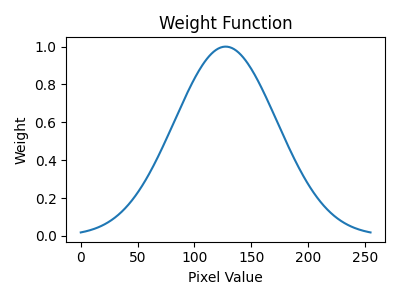

In [197]:
def weight(pixel_values: np.ndarray) -> np.ndarray:
    """Gaussian weighting function Equation (5) in Paper.
    Args:
        pixel_values: Input values of arbitrary shape.
    Returns:
        Gaussian weights for given input according to gaussian function.
        The output array will have the same shape as the input.
    """
    return np.exp(-4 * (pixel_values - 127.5)**2 / 127.5**2)


fig_weight, ax = plt.subplots(1, 1, figsize=[4, 3])
ax.plot(weight(np.arange(256)))
ax.set_title("Weight Function")
ax.set_xlabel("Pixel Value")
ax.set_ylabel("Weight")
fig_weight.tight_layout()

### b) (10 P)
Implement the normalization of the response function `normalize(I)` such that the value in the middle of the range is 1.

In [50]:
def normalize(response: np.ndarray) -> np.ndarray:
    """Normalizes the response curve values such that the median is 1.
    See Paper text after Equation 9
    Args:
        response: Input response values of shape [N]. (Monotonically increasing values)
    Returns:
        Normalized response of shape [N],
        such that result[median_idx] == 1.
    """
    return response / response[len(response) // 2]

# Uncomment this assertion to check if your implementation is correct. Check your code if you get an Assertion error!
assert np.all(normalize(np.array([1, 2, 3])) == np.array([0.5, 1.0, 1.5]))

### c) (20 P)
Reconstruct the HDR image by assuming a known camera response curve.
Implement the function `robertson_apply_response()`, which merges the given LDR-images into one HDR-representation using the given exposure times and response curve for one channel. Consider the docstring of the function.

__Hint:__ You can use [Integer array indexing](https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing) to look up the responses of pixel values. Also to call the weight function for an entire array `arr` you can just call `weight(arr)`.

Test your function with an assumed linear camera response curve and show the tonemapped hdr image by executing the cell.

In [161]:
def show_hdr(response_curve: np.ndarray, hdr: np.ndarray) -> None:
    """Utility function for showing a HDR image on a LDR screen.

    This function uses a tonemapping function implemented in the open-cv library.
    Args:
        response_curve:
            The response curves (I) that were used to reconstruct the HDR image.
            Shape is [C, 256] - one response-curve per channel.
        hdr:
            The HDR iamge that is supposed to be shown.
    
    Raises;
        ValueError: If response curve does not adhere to the shape requirement.
    """
    if not np.all(response_curve.shape == np.array([3, 256])):
        raise ValueError(
            "Response curve must have shape [3, 256]. One response curve for each channel."
        )
    hdr = hdr.astype(np.float32)
    tonemap = cv2.createTonemap(2.2)
    ldr = tonemap.process(hdr)
    fig_hdr, axs = plt.subplots(1, 2, figsize=[8, 3])
    axs[0].semilogx(response_curve[0], np.arange(response_curve.shape[1]), "r-")
    axs[0].semilogx(response_curve[1], np.arange(response_curve.shape[1]), "g-")
    axs[0].semilogx(response_curve[2], np.arange(response_curve.shape[1]), "b-")
    axs[0].set_title("Response Curves (rgb)")
    axs[1].imshow(ldr)
    axs[1].set_axis_off()
    axs[1].set_title("HDR (tonemapped)")

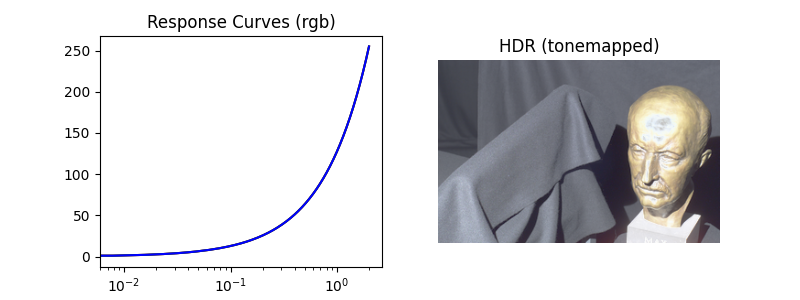

In [178]:
def robertson_apply_response(
    ldr_images: List[np.ndarray], times: List[float], I: np.ndarray, channel: int
) -> np.ndarray:
    """Computes HDR image from ldr images by applying the given response curve I for one channel.
    See paper Equation (8).
    Args:
        ldr_images:
            A list of ldr images of length N and shape [H, W, C].
            Expected type: np.uint8
            Expected value range: [0, 255]
        times:
            A list of exposure times of length N.
        I:
            The response curve lookup table for one channel.
            Array of shape [256].
        channel:
            The chanel to reconstruct. In range [0, C[
    Returns:
        The hdr image of shape [H, W]
    """
    
    ldr_images = np.asarray(ldr_images)
    times = np.asarray(times)
    
    
    numerator = (weight(ldr_images[:,:,:,channel]) * times[:,None,None] * I[ldr_images[:,:,:,channel]]).sum(axis=0)
    denominator = (weight(ldr_images[:,:,:,channel]) * np.square(times[:,None,None])).sum(axis=0)
    
    return numerator / denominator
    
    

# Lets see what your code produces.
# This is a linear response curve with values between 0 and 2.
I = np.linspace(0, 2, 256)
# Lets see how the reconstruction looks like with a linear response curve.
hdr_linear_r = robertson_apply_response(images, exposure_times, I, 0)
hdr_linear_g = robertson_apply_response(images, exposure_times, I, 1)
hdr_linear_b = robertson_apply_response(images, exposure_times, I, 2)
show_hdr(
    np.stack([I, I, I], 0), np.stack([hdr_linear_r, hdr_linear_g, hdr_linear_b], -1)
)

### d) (20 P)
Recover the real (non-linear) camera response curve for the given image set. Implement the function `robertson_get_response()`. Please read the docstring to get an idea how the function should work.

Make sure to fill in unobserved response curve entries somehow to get monotonically increasing values in the array.

__Hint:__ You can count the number of pixels having a specific value using `np.sum(image == value)`.

In [210]:
def robertson_get_response(
    ldr_images: List[np.ndarray],
    times: List[float],
    hdr_image: np.ndarray,
    channel: int,
) -> np.ndarray:
    """Estimate the camera response curve given a ldr-sequence with exposure times and a corresponding hdr_image.
    See Equation (10)
    Args:
        ldr_images:
            List of LDR images captured by camera. Length N, image shape [H, W, C].
            Expected type: np.uint8
            Expected value range: [0, 255]
        times:
            Exposure times (s) corresponding to each LDR-image. Length N.
        hdr_image:
            A HDR image for the current channel that was reconstructed from the LDR-images. Shape [H, W].
        channel:
            The channel whose response curve is supposed to be estimated.
    Returns:
        An estimate for the response curve for the given channel.
        The returned curve is guaranteed to be monotone.
    """
    
    ldr_images = np.asarray(ldr_images)
    
    E = [np.argwhere(ldr_images[:,:,:,channel] == i) for i in range(256)]
    card = [E[i].shape[0] for i in range(256)]

    curve = [1 / card[i] * sum([times[j] * hdr_image[k,l] for (j,k,l) in E[i]]) for i in range(256)]
    for i in range(len(curve) - 1):
        if curve[i] > curve[i+1]:
            curve[i+1] = curve[i]
            
    return curve

### e) (15 P)
Finally implement the HDR reconstruction for unknown response functions. Thus starting from an initial camera response `I` compute the HDR image and new response curve in an alternating fashion until convergence as described in the paper.
Make sure to always normalize the response curve before using it!

optimization:   0%|          | 0/100 [00:00<?, ?it/s]

optimization:   0%|          | 0/100 [00:00<?, ?it/s]

optimization:   0%|          | 0/100 [00:00<?, ?it/s]

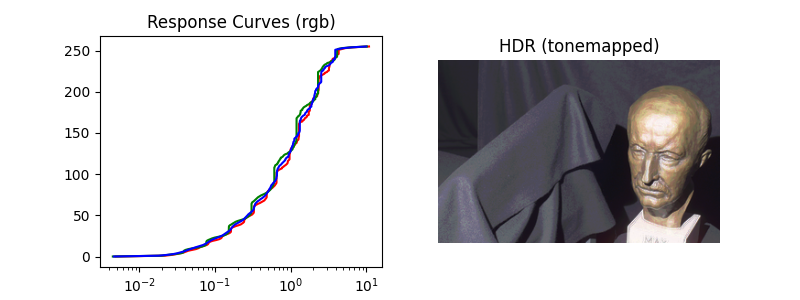

In [211]:
def robertson_unknown_response(
    ldr_images: List[np.ndarray], times: List[float], I: np.ndarray, channel: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Optimizes the response curve by iteratively reconstructing the hdr with
    the current response curve and then refining the response curve values.
    Args:
        ldr_images:
            A list of ldr images of length N and shape [H, W, C].
            Expected type: np.uint8
            Expected value range: [0, 255]
        times:
            A list of exposure times of length N.
        I:
            Initial response curve for the current channel of shape [256].
    Returns:
        A tuple of the optimized response curve and the reconstructed hdr image:
        (response_curves, hdr_image), where response_curve has shape [256]
        and hdr_image has shape [H, W].
    """
    # Optimization stops after this many iterations.
    max_iterations = 100
    # If the sum of squared differences between new and previous response curve are smaller than this stop optimization.
    max_delta = 5e-4

    # TODO: Make sure the response curve I is normalized in the beginning.
    I = normalize(I)
    
    # We do a "deep copy" of the initial response curve.
    # Note: a simple I_previous = I will not copy the array values, just the reference!
    # We need to keep track of the old response curve to check the stopping condition in the end.
    I_previous = I.copy()
    
    # TODO use the initial response curve to reconstruct the initial hdr_image.
    hdr_image = robertson_apply_response(ldr_images, times, I, channel)
    
    # optimization
    delta = max_delta + 1
    bar = tqdm(range(max_iterations), desc="optimization")
    for iteration in bar:
        # step 1: Minimize with respect to I
        I = robertson_get_response(ldr_images, times, hdr_image, channel)

        # step 2: Mormalize I.
        I = normalize(I)

        # step 3: Apply new response (minimize wrt. hdr_image).
        hdr_image = robertson_apply_response(ldr_images, times, I, channel)

        # step 4: Check stopping condition for early stop (sum of squared differences of response curve update).
        delta = np.sum(np.square(I_previous - I))
        if delta < max_delta:
            break
        
        # TODO: keep track of response curve before updating it again.
        I_previous = I.copy()

    return (I, hdr_image)


# We again start with a linear response curve, but this time we optimize for the correct respone curve.
I_init = np.linspace(0, 2, 256)
# Call your robertson_unknown_response for each channel to reconstruct both the color hdr image as well as the response curves for each channel.
I_0, hdr_0 = robertson_unknown_response(images, exposure_times, I, 0)
I_1, hdr_1 = robertson_unknown_response(images, exposure_times, I, 1)
I_2, hdr_2 = robertson_unknown_response(images, exposure_times, I, 2)
I_result = np.stack([I_0, I_1, I_2], 0)
hdr = np.stack([hdr_0, hdr_1, hdr_2], -1)

# Display the result.
show_hdr(I_result, hdr)

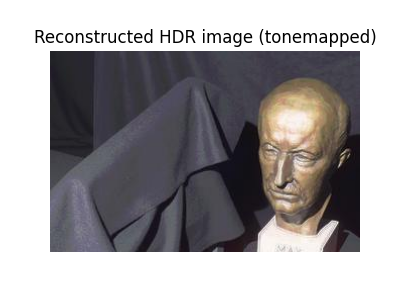

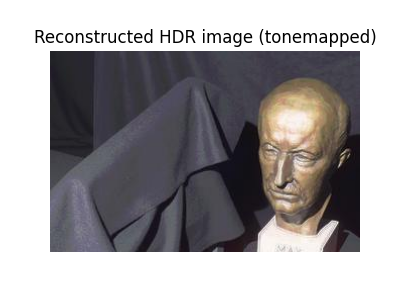

In [152]:
fig, ax = plt.subplots(1, 1, figsize=[4, 3])
ax.imshow(hdr_gt)
ax.set_axis_off()
ax.set_title("Reconstructed HDR image (tonemapped)")
fig.show()

In [193]:
robertson_get_response(images, exposure_times, robertson_apply_response(images, exposure_times, I, 0), 0)

[341195, 24115, 18209, 9929, 8739, 9244, 7440, 6335, 7130, 8156, 8494, 6102, 4616, 4283, 4720, 4789, 4589, 4064, 3962, 4320, 4899, 5611, 5485, 5001, 4055, 3046, 2813, 2843, 3026, 3086, 3087, 3087, 2565, 2313, 2084, 2219, 2344, 2462, 2813, 3078, 3070, 3221, 3198, 2919, 2454, 2089, 1839, 1776, 1675, 1779, 1854, 1884, 1978, 2023, 1994, 1862, 1752, 1570, 1436, 1296, 1287, 1353, 1335, 1434, 1507, 1471, 1621, 1756, 1833, 1915, 2063, 1982, 2021, 1766, 1635, 1405, 1271, 1135, 1018, 930, 931, 964, 916, 955, 953, 1060, 1059, 1044, 1118, 1068, 1078, 968, 953, 989, 882, 899, 892, 890, 793, 800, 740, 814, 871, 853, 845, 885, 945, 880, 960, 920, 1036, 1008, 1168, 1189, 1154, 1189, 1270, 1318, 1229, 1254, 1261, 1106, 1106, 1035, 946, 837, 817, 656, 610, 608, 633, 508, 529, 557, 519, 490, 491, 520, 538, 585, 559, 570, 586, 596, 583, 597, 614, 617, 549, 596, 587, 594, 554, 599, 525, 511, 523, 502, 514, 470, 478, 493, 460, 455, 475, 457, 444, 441, 432, 440, 447, 443, 456, 416, 452, 475, 448, 452, 429, 4

[0.0047593211048093794,
 0.02185333535565204,
 0.026849016875847266,
 0.030761930754422257,
 0.03410919811980235,
 0.03759991010186992,
 0.04112262374132095,
 0.04624933780047356,
 0.05100452207787133,
 0.05475446982171848,
 0.057985382036,
 0.06156486759501874,
 0.06609118215932658,
 0.07040138602951215,
 0.07500058017532588,
 0.07712881320259404,
 0.08027612238810423,
 0.08499939810456603,
 0.0928862768674561,
 0.09939524763031611,
 0.10515283572897416,
 0.10952637512307035,
 0.11431193392836493,
 0.1191133146579706,
 0.12222883501834927,
 0.12814013772418342,
 0.13367014237576852,
 0.14158738998254086,
 0.1479328749534515,
 0.15356423446820158,
 0.15816398163504636,
 0.15314304661344164,
 0.15255547173702722,
 0.15331125081912153,
 0.15955790105052975,
 0.1681416923251869,
 0.1789448773197263,
 0.18829258578048058,
 0.1977649976884594,
 0.2047680341841864,
 0.20943905312463412,
 0.21491529352221359,
 0.22298024400137026,
 0.22458679935969864,
 0.22821263063631497,
 0.233094348429088